# Raleigh FD stations report

In [1]:
%matplotlib inline

In [2]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date
import seaborn as sns
from scipy import stats
import gmaps
import gmaps.datasets
from config import gkey
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Importing and cleaning data for reports on year, station
- API Calls were performed in FireDataAPI
- The main dataset and one that consistently failed in the loop (records 122000-123999) were merged into one in FireDatacsv.
- The merged dataset was cleaned of any nulls in 'incident type' code
- Importing that combined data for analysis

##### Importing the cleaned/combined data from the csv with the years 2008-2018

In [3]:
firefile = './output/all_with_no_incident_nulls.csv'
df = pd.read_csv(firefile, skip_blank_lines=True, encoding='UTF-8',low_memory=False)
len(df)

159803

##### Reformatting the dates to datetime 

In [4]:
df['arrive_date_time'] = pd.to_datetime(df['arrive_date_time'])
df['cleared_date_time'] = pd.to_datetime(df['cleared_date_time'])
df['dispatch_date_time'] = pd.to_datetime(df['dispatch_date_time'])
df.dtypes

OBJECTID                              int64
address                              object
address2                             object
apt_room                             object
arrive_date_time             datetime64[ns]
cleared_date_time            datetime64[ns]
dispatch_date_time           datetime64[ns]
exposure                              int64
incident_number                      object
incident_type                       float64
incident_type_description            object
platoon                              object
station                             float64
Longitude                            object
Latitude                             object
Year                                float64
Date                                 object
dtype: object

##### Getting rid of the decimal in the year column, an artifact of the export perhaps

In [5]:
df['Year'] = df['Year'].astype(float).map("{:.0f}".format)

##### The total number of rows with the years 2008-2018 and incident type not null

In [6]:
len(df.loc[df['incident_type'].notnull()])

159803

##### Adding a column with the time from dispatch to cleared in seconds

In [7]:
arr_time = (df['arrive_date_time'] - df['dispatch_date_time'])
arr_time = pd.to_timedelta(arr_time)
df['Seconds'] = arr_time.dt.total_seconds()
df.head(2)

,OBJECTID,address,address2,apt_room,arrive_date_time,cleared_date_time,dispatch_date_time,exposure,incident_number,incident_type,incident_type_description,platoon,station,Longitude,Latitude,Year,Date,Seconds
0,474769,"8332 SHILOH CREEK CT RALEIGH, NC 27603",NaN,,2013-10-19 21:52:00,2013-10-19 21:59:00,2013-10-19 21:47:00,0,13-0030918,150.0,Outside rubbish fire Other,B,22.0,-78.53732007304758,35.891622339123025,2013,2013-10-19,300.0
1,474770,"7513 IDOLBROOK LN RALEIGH, NC 27615",NaN,,2014-02-14 21:49:00,2014-02-14 21:51:00,2014-02-14 21:46:00,0,14-0004846,510.0,Person in distress Other,A,4.0,-78.6476306369254,35.8781858441652,2014,2014-02-14,180.0


# Fire station analysis

In [8]:
# Getting rid of the 38 entries that have no station assigned
dfs = df.loc[df['station'].notnull()]

# Return the count of records scrubbed
len(df.loc[df['station'].isna()])

38

In [9]:
pd.options.mode.chained_assignment = None
dfs['station'] = dfs['station'].astype(int)

### Removed records with no arrival time

In [10]:
# Getting rid of entries with no arrive time.
# These fell into six categories, none of which were measurable incidents
dfn = dfs.loc[dfs['arrive_date_time'].isna()]
no_time = dfn['incident_type_description'].unique()

for item in no_time:
    print(item)

Dispatched & cancelled en route
False alarm or false call Other
Cover assignment standby moveup
Alarm system sounded due to malfunction
Service Call other
Dispatched & cancelled en route                   


In [12]:
dfst = dfs.loc[dfs['arrive_date_time'].notnull()]
len(dfst)

129731

In [13]:
df_year = dfst.groupby('Year')['OBJECTID'].count()
df_year

Year
2008    11893
2009    10915
2010    11178
2011    11349
2012    10982
2013    11071
2014    11529
2015    12060
2016    12563
2017    14423
2018    11768
Name: OBJECTID, dtype: int64

## Total fire incidents per year

In [14]:
ymean = round(df_year.mean(),2)
ymed = round(df_year.median(),2)
sdev = round(df_year.std(),2)
serr = round(df_year.sem(),2)
message = f'Raleigh FD had a mean incident rate of {ymean} per year, median {ymed}, with a standard deviation of {sdev} and error {serr}'
print(message)

ymax = df_year.max()
ymin = df_year.min()
message2 = f'The most incidents came in 2017 when there were {ymax}, the minimum in 2009 when there were {ymin}.'
print(message2)


Raleigh FD had a mean incident rate of 11793.73 per year, median 11529.0, with a standard deviation of 1009.29 and error 304.31
The most incidents came in 2017 when there were 14423, the minimum in 2009 when there were 10915.


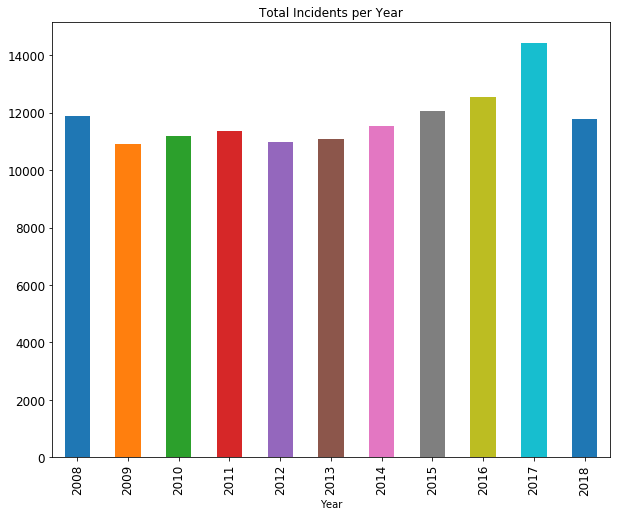

In [15]:
df_year.plot(kind='bar', figsize=(10,8), use_index=True, title='Total Incidents per Year', grid=False,fontsize=12)
plt.savefig('./graphics/total_fi_year.png')

### Fire incidents analysis
- Fire incidents have been on the rise in Raleigh over the period of study
- Raleigh FD had a mean incident rate of 11796.55 per year, median 11529.0, with a standard deviation of 1007.42 and error 303.75
- The most incidents came in 2017 when there were 14423, the minimum in 2009 when there were 10927.

## Station response time

In [16]:
dfst = dfst.loc[dfst['station']!=13]

In [17]:
# There appear to be some funky clearance times, possibly human error
outliers = dfst[dfst['Seconds'] > dfst['Seconds'].mean() + 3 * dfst['Seconds'].std()]
no_outliers = dfst[dfst['Seconds'] <= dfst['Seconds'].mean() + 3 * dfst['Seconds'].std()]

In [18]:
len(outliers)

59

In [19]:
len(no_outliers)

129671

In [20]:
no_outliers['station'] = round(no_outliers['station'],0)
stations_sorted = no_outliers.sort_values('station')
stations_sorted.head()


,OBJECTID,address,address2,apt_room,arrive_date_time,cleared_date_time,dispatch_date_time,exposure,incident_number,incident_type,incident_type_description,platoon,station,Longitude,Latitude,Year,Date,Seconds
91196,579072,"429 S WILMINGTON ST RALEIGH, NC 27601",CHARTER SQUARE PARKING DECK,NaN,2012-08-04 02:17:00,2012-08-04 02:31:00,2012-08-04 02:13:00,0,12-0022154,746.0,Carbon monoxide detector activation no CO,A,1,-78.63834724465839,35.77457035198537,2012,2012-08-04,240.0
115312,607526,"400 N WEST ST RALEIGH, NC 27601",,,2016-05-26 23:05:00,2016-05-26 23:25:00,2016-05-26 23:01:00,0,16-0016157,551.0,Assist police or other governmental agency,C,1,-78.64571299969515,35.78485800021535,2016,2016-05-26,240.0
115311,607525,"1001 FAYETTEVILLE ST RALEIGH, NC 27601",WALNUT TERRACE APTS,,2016-05-23 15:07:00,2016-05-23 15:11:00,2016-05-23 15:04:00,0,16-0015799,622.0,No Incident found on arrival at dispatch address,B,1,-78.64208900000628,35.767279999920184,2016,2016-05-23,180.0
57284,539770,"317 S SALISBURY ST RALEIGH, NC 27601",WAKE CO COURT HOUSE,NaN,2011-12-08 16:59:00,2011-12-08 17:09:00,2011-12-08 16:56:00,0,11-0035597,714.0,Central station malicious false alarm,C,1,-78.6402285198826,35.77673696879105,2011,2011-12-08,180.0
137489,631619,"112 S SALISBURY ST RALEIGH, NC 27601",FIRST PRESBYTERIAN CHURCH,,2017-08-03 22:10:17,2017-08-03 22:24:05,2017-08-03 22:06:37,0,17-0024748,500.0,Service Call other,C,1,-78.64015300031329,35.779275000247644,2017,2017-08-03,220.0


In [21]:
station_means = stations_sorted.groupby('station')['Seconds'].mean()


In [22]:
station_err = stations_sorted.groupby('station')['Seconds'].sem()


In [23]:
station_std = stations_sorted.groupby('station')['Seconds'].std()

In [24]:
overall_mean = round(dfst['Seconds'].mean())
overall_std = round(dfst['Seconds'].std())
overall_err = round(dfst['Seconds'].sem())

print(f'The RFD stations had a {overall_mean} second response time, with standard deviation {overall_std}, error {overall_err}')

The RFD stations had a 307 second response time, with standard deviation 1046, error 3.0


In [25]:
#Removing the outliers
overall_mean = round(no_outliers['Seconds'].mean(), 2)
overall_std = round(no_outliers['Seconds'].std(),2)

print(f'After removing outliers, the RFD stations had a {overall_mean} second response time, with standard deviation {overall_std}.')

After removing outliers, the RFD stations had a 292.35 second response time, with standard deviation 145.54.


In [26]:
slowest = round(station_means.max(), 2)
quickest = round(station_means.min(), 2)
print(f'The station with the fastest response times averaged {quickest} seconds while the slowest averaged {slowest}.')

The station with the fastest response times averaged 232.76 seconds while the slowest averaged 348.36.


In [28]:
slow_stations = []
count = 0
for item, key in station_means.iteritems():
    if (key - overall_mean) > 0:
        slow_stations.append(item)
        count += 1
print(f'There are {count} stations with response times above average: {slow_stations}')

There are 18 stations with response times above average: [2, 4, 6, 8, 11, 15, 16, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


### Plot mean response time per station with errors

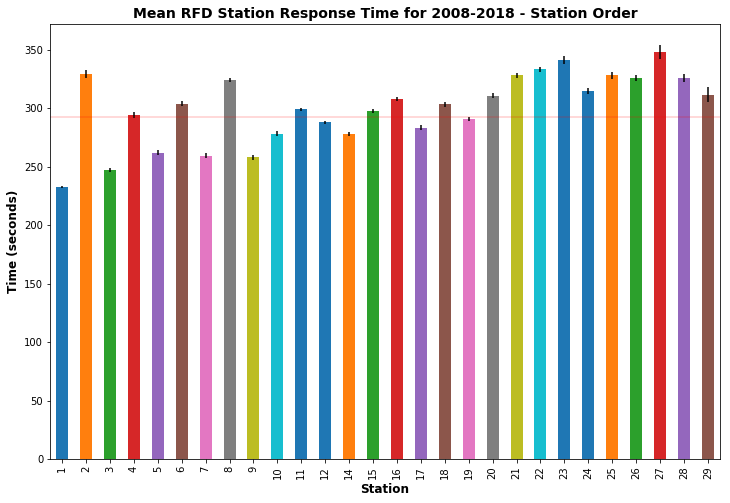

In [94]:
station_means.plot(yerr=station_err, kind='bar')
fig = plt.gcf()
fig.set_size_inches(12, 8)
fig.ylimit=(0,400)
fig.xlimit=(0,30)
plt.hlines(overall_mean, -1, 30, alpha=0.2, label='Overall mean', color='red')
# Add some labels and title
plt.xlabel('Station', fontsize=12, fontweight='bold')
plt.ylabel('Time (seconds)', fontsize=12, fontweight='bold')
plt.title('Mean RFD Station Response Time for 2008-2018 - Station Order', fontsize=14, fontweight='bold')
# Save the figure
plt.savefig('./graphics/station_response_time_summary.png')

In [68]:
incidents_sy = no_outliers.groupby(['Year','station'])['incident_number'].count()
response_sy = no_outliers.groupby(['Year','station'])['Seconds'].mean()
incidents_sy.reset_index()
response_sy.reset_index()
time_inc = pd.concat([incidents_sy, response_sy], axis=1, sort=True, join_axes=[incidents_sy.index])

In [74]:
ys = time_inc.reset_index(level=[0,1])
ys


,Year,station,incident_number,Seconds
0,2008,1,1011,231.216617
1,2008,2,356,302.696629
2,2008,3,557,225.457810
3,2008,4,322,280.993789
4,2008,5,464,264.051724
5,2008,6,505,287.762376
6,2008,7,445,254.292135
7,2008,8,624,305.000000
8,2008,9,488,224.385246
9,2008,10,293,294.470990


/Users/laura/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/laura/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/laura/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/bandwidths.py:20: RuntimeWarning: invalid value encountered in minimum
  return np.minimum(np.std(X, axis=0, ddof=1), IQR)
/Users/laura/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/laura/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/laura/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/

Text(0.5, 1.0, 'RFD Station Response Time Curve')

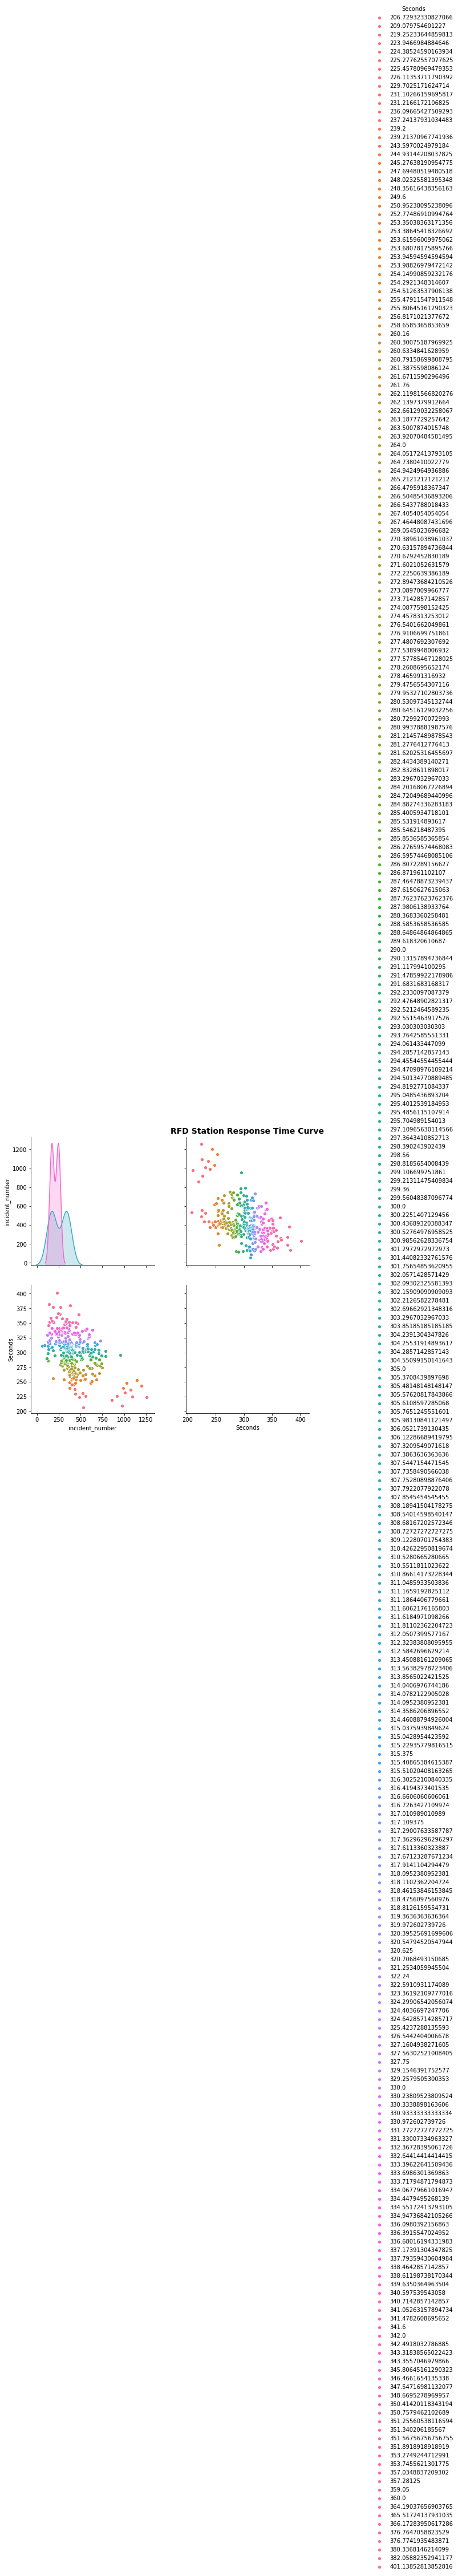

In [84]:
sns.pairplot(data=time_inc, hue='Seconds')
fig = plt.gcf()
fig.set_size_inches(12, 8)
fig.xlimit=(0,400)

# Add some labels and title

plt.xlabel('Time (seconds)', fontsize=12, fontweight='bold')
plt.title('RFD Station Response Time Curve', fontsize=14, fontweight='bold')
# Save the figure
# plt.savefig('./graphics/station_response_time_curve.png'), x='station', y='incident_number', style='Seconds'

### Station Response Time Summary
- There were 10 stations whose response times were above the mean response time: (2, 8, 21, 22, 23, 24, 25, 26, 27, 28)
- The response times are skewed to the right of the normal distribution

##### Scatterplot of mean response time per station/year for further investigation

In [31]:
ss = stations_sorted.groupby(['Year','station'])['Seconds'].mean()
ssu = ss.unstack()
ssu

station,1,2,3,4,5,6,7,8,9,10,...,20,21,22,23,24,25,26,27,28,29
Year,,,,,,,,,,,,,,,,,,,,,
2008,231.216617,302.696629,225.457810,280.993789,264.051724,287.762376,254.292135,305.000000,224.385246,294.470990,...,313.856502,311.618497,295.704989,334.947368,313.450882,255.806452,317.109375,308.727273,298.560000,NaN
2009,209.079755,285.546218,206.729323,270.389610,255.479115,279.953271,239.200000,301.297297,229.702517,253.680782,...,304.255319,308.540146,289.618321,341.052632,302.093023,309.122807,305.576208,285.853659,290.000000,NaN
2010,219.252336,294.061433,231.102662,283.296703,253.615960,298.390244,245.276382,318.812616,237.241379,249.600000,...,314.078212,315.229358,327.750000,320.625000,318.475610,295.048544,334.447950,324.642857,303.296703,NaN
2011,226.113537,310.551181,254.512635,280.645161,256.817102,300.436893,248.356164,323.361921,263.187773,261.671159,...,303.851852,307.792208,343.318386,336.680162,307.735849,330.933333,318.461538,331.272727,315.510204,NaN
2012,243.597002,309.122807,260.300752,299.213115,274.087760,317.914110,261.760000,317.290076,262.119816,277.577855,...,308.189415,324.299065,351.255605,341.478261,327.563025,319.363636,320.395257,330.000000,320.547945,NaN
2013,248.023256,322.240000,254.149909,285.531915,264.000000,311.165919,281.277641,325.423729,260.160000,291.683168,...,307.752809,342.000000,350.757946,366.172840,316.302521,330.238095,311.811024,346.466165,310.866142,NaN
2014,239.213710,357.034884,250.952381,314.095238,266.543779,314.460888,286.595745,340.597540,264.738041,292.521246,...,317.010989,334.067797,333.396226,376.764706,345.806452,365.517241,337.793594,382.058824,333.698630,NaN
2015,236.096654,350.414201,247.694805,308.681672,262.139738,299.106700,253.386454,338.464286,287.464789,286.276596,...,315.375000,340.714286,333.717949,342.491803,337.173913,339.635036,324.403670,351.891892,341.052632,311.186441
2016,252.774869,351.567568,253.945946,305.981308,284.201681,300.985626,266.479592,338.611987,265.212121,304.239130,...,336.391555,348.669528,343.355705,360.000000,315.037594,347.547170,334.551724,376.774194,351.340206,318.095238


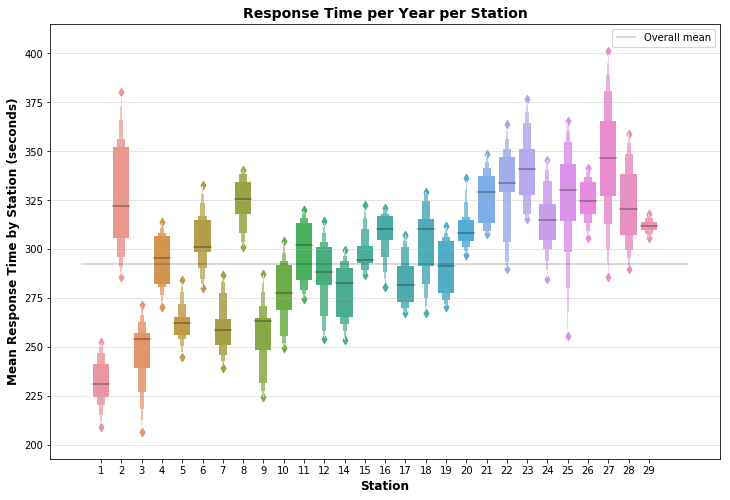

In [36]:
g = sns.boxenplot(data=ssu)
fig = plt.gcf()
fig.set_size_inches(12, 8)
fig.ylimit=(200,400)
fig.xlimit=(0,29)
plt.hlines(overall_mean, -1, 29, alpha=0.2, label='Overall mean')
plt.grid(alpha=0.4, axis='y')
plt.xlabel('Station', fontsize=12, fontweight='bold')
plt.ylabel('Mean Response Time by Station (seconds)', fontsize=12, fontweight='bold')
plt.title('Response Time per Year per Station', fontsize=14, fontweight='bold')
plt.legend(loc='best')
plt.savefig('./graphics/station_response_time_boxen.png')

In [200]:
rfd = pd.read_csv('rfd.csv')
rfd

,station,latitude,longitude,location
0,1,35.777656,-78.643670,"(35.777656,-78.64367)"
1,2,35.748581,-78.647881,"(35.748581,-78.647881)"
2,3,35.779483,-78.632150,"(35.779483,-78.63215)"
3,4,35.882587,-78.648386,"(35.882587,-78.648386)"
4,5,35.788217,-78.661899,"(35.788217,-78.661899)"
5,6,35.809125,-78.655745,"(35.809125,-78.655745)"
6,7,35.792744,-78.612785,"(35.792744,-78.612785)"
7,8,35.786286,-78.708678,"(35.786286,-78.708678)"
8,9,35.841313,-78.643132,"(35.841313,-78.643132)"
9,10,35.741682,-78.613288,"(35.741682,-78.613288)"


In [201]:
station = rfd[['latitude','longitude']]


In [202]:
# Attempted using Gmaps to plot wind data, but there is a flare near Brazil that isn't reflected in the map, 
# think it is just close together datapoints
gmaps.configure(api_key=gkey)

# Center and zoom the map
coordinates = (35.7894263,-78.6388527)

figure_layout = {
    'width': '600px',
    'height': '600px',
    'border': '1px solid black',
    'padding': '1px'
}

fire_layer = gmaps.symbol_layer(station, fill_color='green', stroke_color='blue', scale=2)
fig = gmaps.figure(layout=figure_layout, center=coordinates, zoom_level=6)

fig.add_layer(fire_layer)
fig

Figure(layout=FigureLayout(border='1px solid black', height='600px', padding='1px', width='600px'))

Figure(layout=FigureLayout(height='420px'))

In [140]:
# Create heat layer
heat_layer = gmaps.heatmap_layer(locations, dissipating=False, max_intensity=50,
                                 point_radius=10)

heat_layer.gradient = [
    'white',
'yellow',
'red'
]
# Add layer
fig.add_layer(heat_layer)

# Display figure
fig

TraitError: The 'locations' trait of a Heatmap instance must be of length 1 <= L <= 9223372036854775807, but a value of [] was specified.